# TKT4108 Structural dynamics 2

## Solution exercise 5

**Main topics:** Monte Carlo simulation of time series, auto and cross-correlation, auto and cross-spectral density

**References:** Newland Chapter 4-5




### Problem 1: Simulation of stochastic time series


**a)**

The frequency spacing will be $\Delta \omega=\dfrac{2 \pi}{T}=3.49\cdot 10^{-3}$.


domega is 0.003490658503988659


C:\Users\oyvinpet\AppData\Local\Temp\ipykernel_26440\575607276.py:26: RuntimeWarning: invalid value encountered in divide
  S=(I*U)**2*A*omegaz/(omega*(1+1.5*A*omegaz)**(5/3))


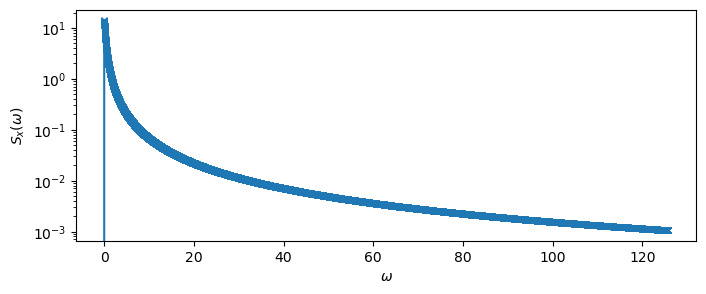

In [71]:
import numpy as np
from matplotlib import pyplot as plt
import time

T=1800
dt=0.05

N=int(T/dt)

t=np.arange(0,N,1)*dt # Time axis

domega=2*np.pi/T # Frequency spacing
print('domega is ' + str(domega))

omega = np.arange(0,N,1)*domega # Frequency axis

# Parameters
A=10.0
I=0.1
z=30.0
U=30.0

omegaz=omega*z/(2*np.pi*U)

# Define spectrum
S=(I*U)**2*A*omegaz/(omega*(1+1.5*A*omegaz)**(5/3))
S[0]=0

# Plot spectrum
plt.figure(figsize=(8,3))
plt.plot(omega,S,marker='x',markersize=5)
plt.ylabel(r'$S_x(\omega)$')
plt.xlabel(r'$\omega$')
plt.yscale('log')

The cosine-sum method is as follows:

$$x(t) = \sum_{k=0}^{N-1}  A_k \cos (\omega_kt + \phi_k) $$

$$A_k = \sqrt{2 S_x(\omega_k) \Delta \omega} $$

Here, $S_x(\omega_k)$ is the auto-spectral density of the process, and $\phi_k$ is random phase angles evenly distributed between $0$ and $2\pi$.

Spent time = 12245.07188796997


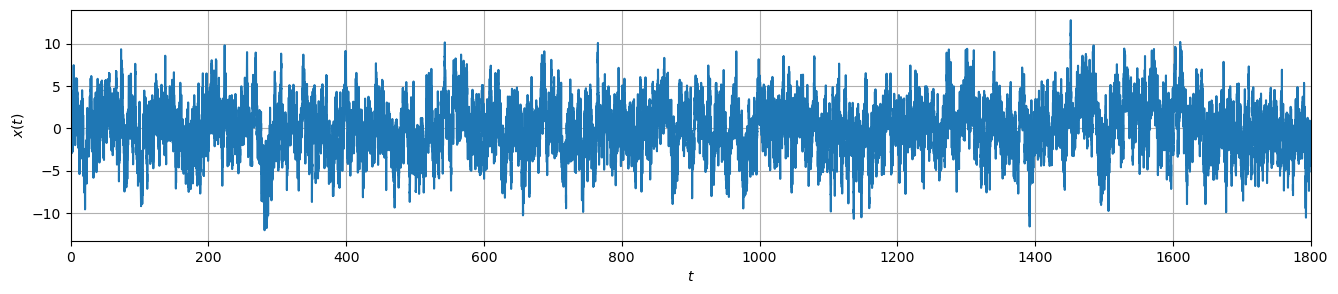

In [72]:
phi = np.random.rand(N)*2*np.pi # Random phase angles 

x = np.zeros_like(t) # Initialize the vector of x values

t0=time.time()
for k in range(N):
    Ak = (2*S[k]*domega)**0.5 #Amplitude
    x = x + Ak * np.cos(omega[k]*t+phi[k]) # Sum the contribution from each harmonic component
t1=time.time()

print('Spent time = ' + str((t1-t0)*1000))

# Plot wind turbulence
plt.figure(figsize=(16,3))
plt.plot(t,x)
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,T)
plt.grid()


The variance is calculated in the time domain from the time series and in the frequency domain as $\sigma^2=\int_{-\infty}^{\infty} S(\omega) \: \text{d}\omega$. These should give the same result.

In [73]:
sd_td=np.std(x) # SD from time series 
sd_fd=np.trapz(S,omega)**0.5 # SD from spectrum

print('Time domain standard deviation is ' + str(sd_td))
print('Frequency domain standard deviation is ' + str(sd_fd))


Time domain standard deviation is 2.962999244727832
Frequency domain standard deviation is 2.96220683590699


**c)**

We start by attempting to double the length of the time vector: $ t \in [0,\: 2 T]$, and repeat the simulation by the cosine sum method.

In [ ]:
t_double=np.arange(0,2*N,1)*dt # Time axis (double length)

x_double = np.zeros_like(t_double) # Initialize the vector of x values

for k in range(N):
    Ak = (2*S[k]*domega)**0.5 #Amplitude
    x_double = x_double + Ak * np.cos(omega[k]*t_double+phi[k]) # Sum the contribution from each harmonic component

plt.figure(figsize=(16,3))
plt.plot(t,x,label='Original')
plt.plot(t_double,x_double,'--',label='Extended time vector')
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,2*T)
plt.legend()
plt.grid()


Upon closer inspection, we observe that the time series from 1800–3600 s (i.e., $T$ to $2T$) is an exact replica of the time series from 0–1800 s ($0$ to $T$). This repetition is a fundamental property of the Fourier series, where we implicitly assume that the time series is periodic with a period $T$. By doubling the length of the time vector without adjusting $\Delta \omega$, the time series simply repeats.

The first cosine wave component, $A_1 \cos (\Delta \omega t)$, will determine the feasible length of the simulation since $\Delta \omega $ is the lowest frequency (the one that takes the longest time to complete one cycle). This argument is the basis for the relationship $T = \dfrac{2 \pi}{\Delta \omega}$.

Doubling the time vector in this way is problematic because it introduces a non-zero auto correlation between the values at times $t$ and $t + T$. As a result, the extended time series no longer has the correct statistical properties, which will affect the statistical results of the calculated dynamic response.

This problem can, however, be solved by simply halving $\Delta \omega$ such that the time vector indeed becomes 1 hour long.




**d)**

The IFFT method is defined as:

$$x(t) = \Re \left(\text{IFFT} \left( A_k e^{i \phi_k} \right) \right)$$



In [ ]:
#phi = np.random.rand(N)*2*np.pi # Random phase angles 

t_ifft = np.arange(0,N,1)*dt # Time axis

t0=time.time()
c = (2*S*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
x_ifft = np.real(np.fft.ifft(c)*N) # The IFFT
t1=time.time()

print('Spent time = ' + str((t1-t0)*1000))

plt.figure(figsize=(16,3))
plt.plot(t,x,label= 'cos method')
plt.plot(t_ifft,x_ifft,label = 'IFFT method',linestyle=':')
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,T)
plt.grid()
plt.legend()

The results are identical to those obtained using the cosine-sum method (when the same phase angles are used). 

However, the IFFT method is significantly faster: approximately 5 ms compared to 15000 ms. This substantial improvement is due to the inherent efficiency of the IFFT algorithm, which reduces computational complexity from $\mathcal{O}(N^2)$ in the cosine-sum approach to $\mathcal{O}(N \log N)$ for the IFFT. For long time series (large $N$), this plays an important role.

Additionally, the way these algorithms are implemented in Python further contributes to the speedup.

### Problem 2: Properties of spectral density

**a)**

The cross-spectral density matrix is defined as:

$$
\mathbf{S}_{\tilde{\mathbf{x}}}(\omega) = \dfrac{1}{2\pi} \int_{-\infty}^{\infty} \mathbf{R}_{\tilde{\mathbf{x}}}(\tau) e^{-i \omega \tau } \:\text{d} \tau
$$


where the cross-correlation matrix is:

$$
\mathbf{R}_{\tilde{\mathbf{x}}}(\tau) = \mathbb{E}[\tilde{\mathbf{x}}(t) \tilde{\mathbf{x}}^\text{T}(t + \tau)]
$$

We can substitute $\tilde{\mathbf{x}}(t) = \mathbf{T} \mathbf{x}(t)$:

$$
\mathbf{R}_{\tilde{\mathbf{x}}}(\tau) = \mathbb{E}[\mathbf{T} \mathbf{x}(t) (\mathbf{T} \mathbf{x}(t + \tau))^\text{T}]
=\mathbf{T} \mathbb{E}[\mathbf{x}(t) \mathbf{x}^\text{T}(t + \tau)] \mathbf{T}^\text{T}
$$

Therefore, the cross-correlation matrix transforms as follows:

$$
\mathbf{R}_{\tilde{\mathbf{x}}}(\tau) = \mathbf{T} \mathbf{R}_{\mathbf{x}}(\tau) \mathbf{T}^\text{T}
$$

Next, we consider the spectral density where $\mathbf{T}$ can be moved outside the integral:

$$
\mathbf{S}_{\tilde{\mathbf{x}}}(\omega) = \dfrac{1}{2\pi} \int_{-\infty}^{\infty} \mathbf{R}_{\tilde{\mathbf{x}}}(\tau) e^{-i \omega \tau}  \:\text{d} \tau
= \dfrac{1}{2\pi} \int_{-\infty}^{\infty} \mathbf{T} \mathbf{R}_{\mathbf{x}}(\tau) \mathbf{T}^\text{T} e^{-i \omega \tau} \:\text{d} \tau
= \dfrac{1}{2\pi} \mathbf{T} \left( \int_{-\infty}^{\infty} \mathbf{R}_{\mathbf{x}}(\tau) e^{-i \omega \tau} \:\text{d} \tau \right) \mathbf{T}^\text{T}
=  \mathbf{T} \mathbf{S}_{\mathbf{x}}(\omega) \mathbf{T}^\text{T}
$$

Such transformation formulas are useful, for instance for a modal transformation.

**b)**

*i)*

We have the definition of the auto correlation of displacement: 

$$R_y(\tau)= \mathbb{E} [y(t) y(t + \tau)] $$

We start by differentiating once:

$$
\frac{\text{d} R_y(\tau)}{\text{d} \tau} 
= \mathbb{E} \left[ y(t) \frac{\text{d} y(t + \tau)}{\text{d} \tau} \right]
= \mathbb{E} \left[ y(t) \frac{\text{d} y(t + \tau)}{\text{d} (t+\tau)}\frac{\text{d} (t + \tau)}{\text{d} \tau} \right]
= \mathbb{E} \left[ y(t) \dot{y}(t + \tau) \right]
$$

In the last term, we now have the cross-correlation between the displacement and velocity. In general, if we take the reverse cross-correlation, the function is mirrored: $ R_{x_2 x_1}(\tau)=R_{x_1 x_2}(-\tau)$. We can therefore say:

$$
\mathbb{E} \left[ y(t) \dot{y}(t + \tau) \right]
=
\mathbb{E} \left[ \dot{y}(t) y(t -\tau) \right]
$$

We can differentiate once more and get:

$$
 \mathbb{E} \left[  \dot{y}(t) \frac{\text{d} y(t - \tau)}{\text{d} \tau} \right]
=
\mathbb{E} \left[ \dot{y}(t) \frac{\text{d} y(t - \tau)}{\text{d} (t-\tau)}\frac{\text{d} (t - \tau)}{\text{d} \tau} \right]
=
-\mathbb{E} \left[ \dot{y}(t) \dot{y}(t-\tau) \right]
$$

We are now dealing with an auto correlation, which is symmetric wrt. $\tau$. We can therefore switch the sign of $\tau$:

$$
-\mathbb{E} \left[ \dot{y}(t) \dot{y}(t-\tau) \right]=-\mathbb{E} \left[ \dot{y}(t) \dot{y}(t+\tau) \right]
$$

We recognize this as the negative auto correlation of the velocity, $-R_{\dot{y}}(\tau)$.

*ii)*

The auto correlation is the inverse Fourier transform of the spectral density:

$$
R_y(\tau) =  \int_{-\infty}^{\infty} S_y(\omega) e^{i \omega \tau } \:\text{d} \tau
$$

We can use the result from *i)*. If we differentiate twice wrt. to $\tau$ and multiply by -1:
$$
R_{\dot{y}}(\tau)=
-\frac{\text{d}^2 R_y(\tau)}{\text{d} \tau^2}  = 
- \int_{-\infty}^{\infty} (i \omega)^2 S_y(\omega) e^{i \omega \tau } \:\text{d} \tau =
 \int_{-\infty}^{\infty} \omega ^2 S_y(\omega) e^{i \omega \tau } \:\text{d} \tau = 
 \int_{-\infty}^{\infty} S_{\dot{y}}(\omega) e^{i \omega \tau } \:\text{d} \tau
$$

We see that $S_{\dot{y}}(\omega)$ must be $\omega ^2 S_y(\omega)$. By the same argument, the spectral density of the acceleration must be
$$ 
S_{\ddot{y}}(\omega)=\omega^4 S_y(\omega)
$$

This is convenient, as the spectral density of process derivatives (velocity, acceleration) can very easily be obtained from the displacement spectrum.


**c)**

White noise is a theoretical spectral density which contains all frequencies (flat spectrum):

$$
S(\omega) 
= \left\{ \begin{array} a \frac{1}{2}  \sigma_x^2 /\omega_{lim} & \quad 
-\omega_{lim} \leq \omega \leq \omega_{lim}
\\ 0 & \quad \text{elsewhere} \end{array} \right.
$$

In the ideal case, the upper limit $\omega_{lim} \rightarrow \infty$, resulting in true white noise. However, in practice, we more often consider cases where the spectrum is flat and bounded, approximating white noise by a rectangular spectrum.

The expected value is zero.

The autocorrelation is $R_x(\tau)=\sigma_x^2 \delta(\tau)$, where $\delta(\tau)$ is the Dirac delta function, implying that white noise is uncorrelated at different time instants.

The probability density function (PDF) of white noise follows a normal distribution: $\mathcal{N}(0,\sigma_x^2)$.


### Problem 3: Impulse response method and frequency response method

**a)** 

We start by assuming that the load is defined as $x(t) = \delta(t)$
 
 Inserting the load into the differential equation provides
 
 $$ m \ddot{y} + c \dot{y} + k y = \delta(t)  $$
 
 The damping and stiffness force is minimal compared to the inertia force during the short impulse. We can therefore neglect these two terms. This approximation becomes exact as the duration of the pulse goes to zero. We can, therefore, consider the following differential equation when considering the response **during** the impulse

$$ m \ddot{y}  = \delta(t)  $$

We can solve the differential equation by integrating both sides.

$$ m \dot{y}  = 1  $$

The velocity of the system at the end of the short pulse is

$$ \dot{y}(t \approx 0)  = \frac{1}{m}  $$

This velocity is then used as an initial condition for the system's response **after** the short impulse. The free vibration response of a single degree of freedom system is defined as

$$ y(t) = e^{-\xi \omega_n t} \left( A \sin\left(\omega _ D t \right ) + B \cos\left(\omega _ D t \right) \right)   $$ 

Here $\omega _ D$ is the damped natural frequency of the system, $\omega _ n$ is the undamped natural frequency, and $\xi$ is the damping ratio. The displacement is approximately zero after the impulse, and the time is close to zero. This means that $B = 0$. The free vibration response can thus be written as

$$ y(t) = e^{-\xi \omega_n t} A \sin\left(\omega _ D t \right )  $$

Taking the derivative of the response renders

$$ \dot{y}(t) = -\xi \omega_n e^{-\xi \omega_n t} A \sin\left(\omega _ D t \right ) +
e^{-\xi \omega_n t} A \cos\left(\omega _ D t \right )\omega _ D$$

introducing the initial condition

$$ \dot{y}(t \approx 0)  = \frac{1}{m}  $$

$$ A = \frac{1}{m \omega_D}   $$

The free vibration response after  can thus be expressed as

$$ y(t) = e^{-\xi \omega_n t} \frac{1}{m \omega_D}  \sin\left(\omega _ D t \right )  $$

A general loading can be approximated as a series of impulse loads and the response due to an impulse occurring at time $\tau$ can be expressed as

$$ h(t-\tau) = e^{-\xi \omega_n (t-\tau)} \frac{1}{m \omega_D}  \sin\left(\omega _ D (t-\tau) \right ) $$

The total response can be obtained by taking the sum of the response from all short impulses, which corresponds to integrating the response.

$$y(t) = \int_{-\infty}^{t} h(t-\tau) x(\tau) d\tau $$
 
The impulse response is zero when $t-\tau<0$, which implies that the integral can be written as follows:

 $$y(t) = \int_{-\infty}^{\infty} h(t-\tau) x(\tau) d\tau $$
 

**b)** 

This is a rectangular spectrum (approximating white noise). We can simulate using the IFFT-method from problem 1.



In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import time

T=600 # Simulation length
dt=0.05 # Time step

N=int(T/dt)

t = np.arange(0,N,1)*dt # Time axis

domega=2*np.pi/T # Frequency spacing

omega_axis = np.arange(0,N,1)*domega # Frequency axis

S=np.zeros_like(omega_axis)
S[(omega_axis>0) & (omega_axis<50)]=10

phi = np.random.rand(N)*2*np.pi # Random phase angles 

c_amp = (2*S*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
x = np.real(np.fft.ifft(c_amp)*N) # The IFFT

# Plot
plt.figure(figsize=(16,3))
plt.plot(t,x,label='Load')
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.title('Load')
plt.xlim(0,T)
plt.xlim(0,100)
plt.grid()
plt.legend()


**c)**


In [ ]:
# Structural properties
m = 100
omega_n = 1*2*np.pi
zeta = 5/100

k = m*omega_n**2 
c = 2*m*zeta*omega_n

tau_axis=t

y_td=np.zeros_like(t) # Initialize y

t0=time.time()
for n in range(len(t)): # Solve convolution integral for each t

    t_minus_tau=t[n]-tau_axis

    h=np.exp(-zeta*omega_n*t_minus_tau)*1/(m*omega_n)*np.sin(omega_n*t_minus_tau)

    idx=t_minus_tau>0 # Only consider range where this is positive (nothing happens before t=0)
    
    y_td[n]=np.trapz(x[idx]*h[idx],tau_axis[idx])
    
t1=time.time()

print('Spent time = ' + str((t1-t0)*1000))


# Solve also by Newmarks method for extra verification
import sys
sys.path.append('./../../modules')
from time_integration import * # Import all functions in the module time_integration

u0=0
udot0=0
y_newmark, ydot, y2dot = linear_newmark_krenk(m,c,k,x,u0,udot0,dt)

# Plot
plt.figure(figsize=(16,3))
plt.plot(t,y_td,label='Solved by IRF')
plt.plot(t,y_newmark[0,:],label='Solved by Newmark')
plt.ylabel(r'$y(t)$')
plt.xlabel(r'$t$')
plt.title('Displacement response')
plt.xlim(0,100)
plt.grid()
plt.legend()


The responses are similar, as expected.




**d)** 

To derive the frequency response method, we assume that the load is harmonic with unit amplitude $x(t) = e^{i\omega t}$. We further assume that the particular solution takes the form $y=H(\omega)e^{i \omega t}$

Inserting the particular solution into the equation of motion renders:

$$ \left(-\omega^2 m + i \omega c  + k\right)H(\omega)e^{i\omega t} = e^{i\omega t} $$

The frequency response function of the system is:

$$ H(\omega) = \frac{1}{\left(-\omega^2 m + i \omega c  + k\right)} $$

The frequency response method can be summarized in the following manner.

1) Take the Fourier transform of the load (Approximate by using a Fourier series)
    
2) Multiply the Fourier transform of the load with the frequency response function to get the Fourier transform of the response

3) Obtain the response by taking the inverse Fourier transform of the Fourier transform of the response

It is important to remember that following the above procedure assumes that the loading is periodic. It is, therefore, necessary to ensure that the load is zero for a sufficiently long time at the end of the time series to ensure that the response has time to settle to zero. Any remaining response at the end of the calculated time series will be introduced as initial conditions and will, therefore, reduce the accuracy of the solution significantly. 



In [ ]:
t0=time.time()

# Load in the frequency domain
x_fft = np.fft.fft(x)/N # DFT
f_fft = np.fft.fftfreq(N, d=dt) # Frequency axis in Hz

omega_fft=2*np.pi*f_fft

# Frequency response function
H=1/(-omega_fft**2*m+1j*omega_fft*c+k)

# Response in the frequency domain
y_fft=H*x_fft

# Response in the time domain
y_fd= np.fft.ifft(y_fft)*N # IDFT

t1=time.time()

print('Spent time = ' + str((t1-t0)*1000))

# Plot
plt.figure(figsize=(16,3))
plt.plot(t,y_td,label='Solved by IRF')
plt.plot(t,y_fd,label='Solved by FRF')
plt.plot(t,y_newmark[0,:],label='Solved by Newmark')
plt.ylabel(r'$y(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,T)
plt.xlim(0,100)
plt.grid()
plt.legend()


The responses are similar, as expected.


**e)** 

The FFT-based method are faster than doing a numerical trapezoidal integration to solve the convolution (approx. 3000 ms vs. 3 ms). 

In addition, frequency domain solutions are easier to implement than convolution integrals.